## <span style="color:#a4d4a3"> **Motion and Observation Models** </span>

Below we detail common motion and observation models used in SLAM and provide a few `python` examples.

---

### 🪃 <span style="color:#a4d4a3"> **Motion Models** </span>

In robotics, the <span style="color:#ffa500">**motion model**</span> describes how the robot state evolves from one time step to the next, given a previous state and a control input. Specifically, it provides the posterior probability that a control action $u_t$ moves the robot from state $x_{t-1}$ to state $x_t$:

$$
p(x_t \mid u_t, x_{t-1})
$$

As previously discussed in the context of the Bayes Filter, we need a way to explicitly model the uncertainty in robot motion, as real-world motion always involves <span style="color:#ffa500">**inherent uncertainty**</span>.

Two common motion models used in practice are:

1. <span style="color:#00703c">**Odometry-based Motion Model**</span> (typically used for wheeled robots).
2. <span style="color:#00703c">**Velocity-based Motion Model**</span> (often employed for aerial or legged robots).

#### <span style="color:#a4d4a3"> 1. Odometry-based Motion Model (for wheeled robots) </span>

The odometry model relies on wheel encoders, which count wheel rotations to estimate robot displacement. However, factors like tire pressure differences, wheel slippage, or uneven terrain can introduce drift over time. Thus, odometry measurements inherently contain uncertainty.

 <span style="color:#a4d4a3">**Odometry Measurements:**</span>

Given the previous robot pose $(\bar{x}, \bar{y}, \bar{\theta})$ and the new robot pose after movement $(\bar{x}', \bar{y}', \bar{\theta}')$, we define the odometry measurement $u$ as a vector of rotational and translational changes:

$$
u = (\delta_{rot1}, \delta_{trans}, \delta_{rot2})^T
$$

<p align="center">
  <img src="../figures/odom_model.png" alt="Robot Odometry" width="640"/>
</p>

where each component is calculated as follows:

- **Translational displacement**:
$$
\delta_{trans} = \sqrt{(\bar{x}' - \bar{x})^2 + (\bar{y}' - \bar{y})^2}
$$

- **Initial rotation** (to face the direction of motion):
$$
\delta_{rot1} = \text{atan2}(\bar{y}' - \bar{y},\, \bar{x}' - \bar{x}) - \bar{\theta}
$$

- **Final rotation** (to reach the final orientation):
$$
\delta_{rot2} = \bar{\theta}' - \bar{\theta} - \delta_{rot1}
$$

In other words, the motion is decomposed into three sequential steps:

1. An initial rotation ($\delta_{rot1}$) aligning the robot toward the target position.
2. A translational motion ($\delta_{trans}$) moving the robot forward to the new location.
3. A final rotation ($\delta_{rot2}$) aligning the robot with its desired orientation.

 <span style="color:#a4d4a3">**Modeling Uncertainty:**</span>

Due to inherent noise, uncertainty in these measurements is typically modeled as <span style="color:#ffa500">**additive Gaussian noise**</span> in each odometry measurement:

$$
u_{noisy} = u + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \Sigma)
$$

where $\Sigma$ is the covariance matrix representing uncertainty in rotations and translation.

---

##### 📈 `Python Example #1: Odometry-based Motion Model`

First, we define the <span style="color:#ffa500">**odometry-based motion model**</span> according to the equations provided earlier.

In [32]:
# Sample motion model for a robot using odometry data
import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
# np.random.seed(42)

# --- Motion model ---
def motion_model_odometry(u:np.array, x_prev:np.array, noise_std:np.array=[0, 0, 0]) -> np.array:
    """
    Simulates the robot's motion given odometry commands and previous state.
    Inputs:
    - u: Odometry command (delta_rot1, delta_trans, delta_rot2)
    - x_prev: Previous state (x, y, theta)
    - noise_std: Standard deviations for Gaussian noise added
    Returns:
    - x: New state (x, y, theta)
    """
    delta_rot1, delta_trans, delta_rot2 = u
    
    # Add Gaussian noise to odometry commands
    delta_rot1_hat = delta_rot1 + np.random.normal(0, noise_std[0])
    delta_trans_hat = delta_trans + np.random.normal(0, noise_std[1])
    delta_rot2_hat = delta_rot2 + np.random.normal(0, noise_std[2])
    
    # Compute new state
    x = x_prev[0] + delta_trans_hat * np.cos(x_prev[2] + delta_rot1_hat)
    y = x_prev[1] + delta_trans_hat * np.sin(x_prev[2] + delta_rot1_hat)
    theta = x_prev[2] + delta_rot1_hat + delta_rot2_hat
    
    return np.array([x, y, theta])

Then, we define an initial position and a set of desired odometry commands $ u $. We feed these commands to the motion model to generate trajectories for two cases:

- One <span style="color:#ffa500">**without noise**</span>, representing the <span style="color:#ffa500">**ideal**</span> (ground truth) trajectory.
- One <span style="color:#ffa500">**with Gaussian noise**</span>, representing <span style="color:#ffa500">**realistic**</span> conditions.

In [33]:
# Initial state [x, y, theta]
x_start = np.array([0, 0, 0])

# Odometry commands [rot1, trans, rot2], you can play with these values
commands = [
    [np.pi/4, 1.0, np.pi/4],
    [0, 1.5, 0],
    [-np.pi/2, 2.0, -np.pi/4],
    [np.pi/2, 1.0, 0]
]

# Ground truth trajectory (noise-free)
trajectory_gt = [x_start]

# Noisy trajectory (with odometry noise)
trajectory_noisy = [x_start]

x_gt = x_start.copy()
x_noisy = x_start.copy()

# Iterate over commands and update trajectories
for u in commands:
    # Ground truth update (no noise)
    x_gt = motion_model_odometry(u, x_gt)
    trajectory_gt.append(x_gt)
    
    # Noisy update
    x_noisy = motion_model_odometry(u, x_noisy, noise_std=[0.06, 0.1, 0.06])
    trajectory_noisy.append(x_noisy)

trajectory_gt = np.array(trajectory_gt)
trajectory_noisy = np.array(trajectory_noisy)

Below, we visualize both trajectories. The noisy trajectory clearly demonstrates how uncertainty from odometry can cause drift over time.

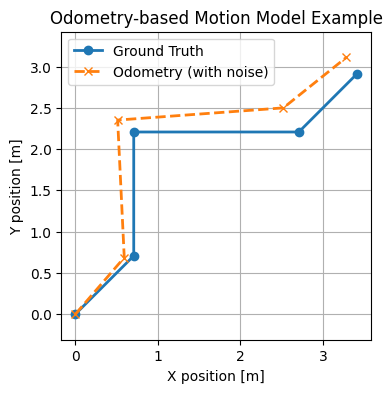

In [34]:
# Plotting the trajectories
plt.figure(figsize=(4, 4)) # Adjust figure size for better visibility
plt.plot(trajectory_gt[:,0], trajectory_gt[:,1], 'o-', label='Ground Truth', linewidth=2)
plt.plot(trajectory_noisy[:,0], trajectory_noisy[:,1], 'x--', label='Odometry (with noise)', linewidth=2)
plt.grid(True)
plt.axis('equal')
plt.title('Odometry-based Motion Model Example')
plt.xlabel('X position [m]')
plt.ylabel('Y position [m]')
plt.legend()
plt.show()

Additionally, we illustrate how the uncertainty in each odometry command (rotation-only, translation-only, and combined) affects the resulting distribution of poses in 2D space.

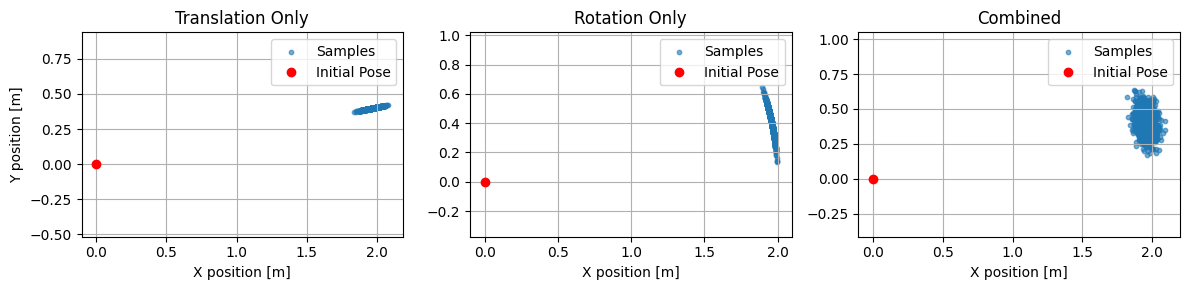

In [35]:
# Plot the distribution of samples from the motion model with different noise scenarios
# Initial pose and odometry command (straight motion)
initial_pose = np.array([0.0, 0.0, 0.0])
odometry_command = [0.2, 2.0, 0.0]  # initial heading, translate 2 m, no rotation

# Define noise scenarios using the same noise_std signature
scenarios = {
    'Translation Only': [0.0, 0.04, 0.0],
    'Rotation Only':    [0.04, 0.0, 0.04],
    'Combined':         [0.04, 0.04, 0.04]
}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 3)) # Adjust figure size for better visibility

for ax, (title, noise) in zip(axes, scenarios.items()):
    # Generate samples by repeatedly calling the single-sample function
    samples = np.array([motion_model_odometry(odometry_command, initial_pose, noise) for _ in range(1000)])
    ax.scatter(samples[:, 0], samples[:, 1], s=10, alpha=0.6, label='Samples')
    ax.plot(initial_pose[0], initial_pose[1], 'ro', label='Initial Pose')
    ax.set_title(title)
    ax.set_xlabel('X position [m]')
    if ax is axes[0]:
        ax.set_ylabel('Y position [m]')
    ax.axis('equal')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


---


#### <span style="color:#a4d4a3"> 2. Velocity-based Motion Model </span>

Typically, a velocity-based motion model is expressed through two velocities: (i) a translational velocity and (ii) a rotational velocity. This results in an <span style="color:#ffa500">**arc-like trajectory**</span> for the robot's motion.

In this model, we define:

- Translational velocity: $v$
- Rotational velocity: $w$

Given the current robot state $(x, y, \theta)$ and the control input vector $u = (v, w)^T$, the updated robot state $(x', y', \theta')$ after applying these controls for a time interval $\Delta t$ is computed as follows:

<p align="center">
  <img src="../figures/velocity_model.png" alt="Robot Odometry" width="520"/>
</p>

<br>

$$
\begin{pmatrix}
x' \\[6pt]
y' \\[6pt]
\theta'
\end{pmatrix} 
=
\begin{pmatrix}
x \\[6pt]
y \\[6pt]
\theta
\end{pmatrix} 
+
\begin{pmatrix}
-\frac{v}{w}\sin\theta + \frac{v}{w}\sin(\theta + w \Delta t) \\[6pt]
\frac{v}{w}\cos\theta - \frac{v}{w}\cos(\theta + w \Delta t) \\[6pt]
w \Delta t + \gamma \Delta t
\end{pmatrix}
$$

<br>

> 📝 <span style="color:#0098ff">**Note:**</span> <em>Arc-like motion alone doesn't allow specification of a particular final orientation. Therefore, we often add an extra term $ \gamma \Delta t $ to adjust the orientation explicitly. </em>

---

##### 📈 `Python Example #2: Velocity-based Motion Model`

First, we define the <span style="color:#ffa500">**velocity-based motion model**</span> according to the equations provided earlier. This model uses three control inputs: (i) translational velocity $ v $, (ii) rotational velocity $ w $, and (iii) an additional term $ \gamma $ for adjusting the orientation explicitly.

In [36]:
# Sample motion model using velocity commands

# --- Motion model ---
def motion_model_velocity(u:np.array, x_prev:np.array, dt:float=1.0, noise_std:np.array=[0, 0, 0]) -> np.array:
    """
    Sample velocity-based motion model particles.
    Inputs:
    - u: control commands [v, w, gamma]
    - x_prev: previous state [x, y, theta]
    - dt: time interval
    - noise_std: standard deviations for [v, w, gamma] noise
    Returns:
    - x: new state [x', y', theta']
    """
    v, w, gamma = u
    
    # Add Gaussian noise to controls
    v_hat = v + np.random.normal(0, noise_std[0])
    w_hat = w + np.random.normal(0, noise_std[1])
    gamma_hat = gamma + np.random.normal(0, noise_std[2])
    
    # Compute new state with velocity model
    if abs(w_hat) > 1e-6:
        x_new = x_prev[0] - (v_hat/w_hat) * np.sin(x_prev[2]) + (v_hat/w_hat) * np.sin(x_prev[2] + w_hat*dt)
        y_new = x_prev[1] + (v_hat/w_hat) * np.cos(x_prev[2]) - (v_hat/w_hat) * np.cos(x_prev[2] + w_hat*dt)
    else:
        # Straight line when w is zero
        x_new = x_prev[0] + v_hat * dt * np.cos(x_prev[2])
        y_new = x_prev[1] + v_hat * dt * np.sin(x_prev[2])
    theta_new = x_prev[2] + w_hat * dt + gamma_hat * dt

    return np.array([x_new, y_new, theta_new])

Then, we define an initial position and a set of desired velocity commands $ u = [v, w, \gamma]^T $. By sequentially applying these commands, we generate two trajectories:

- One **without noise**: the ideal trajectory (ground truth).
- One **with Gaussian noise**: simulating realistic conditions.

In [37]:
# Initial state
initial_pose = np.array([0.0, 0.0, 0.0])
control = [1.0, 0.3, 0.1]  # v, w, # Define a sequence of varied controls to create a non-circular path
control_sequence = [
    [1.0,  0.0,  0.0],  # straight
    [1.0,  0.5,  0.0],  # turn right
    [1.0,  0.0,  0.0],  # straight
    [1.0, -0.5,  0.0],  # turn left
    [1.0,  0.0,  0.0],  # straight
    [1.0,  0.5,  0.0],  # turn right again
    [1.0,  0.0,  0.0],  # straight
    [1.0, -0.5,  0.0],  # turn left again
    [1.0,  0.0,  0.2],  # adjust orientation
    [1.0,  0.0, -0.2]   # adjust orientation back
]

initial_pose = np.array([0.0, 0.0, 0.0])
num_steps = len(control_sequence)

# Allocate trajectories
traj_gt = np.zeros((num_steps+1, 3))
traj_noisy = np.zeros((num_steps+1, 3))
traj_gt[0] = initial_pose
traj_noisy[0] = initial_pose

# Simulate
for t, u in enumerate(control_sequence, start=1):
    traj_gt[t] = motion_model_velocity(u, traj_gt[t-1], dt=1.0)
    traj_noisy[t] = motion_model_velocity(u, traj_noisy[t-1], dt=1.0, noise_std=[0.05,0.075,0.05])


Below, we visualize both trajectories. The noisy trajectory illustrates how uncertainty in velocity commands causes the robot’s actual trajectory to drift from the ideal path, especially as errors accumulate over multiple steps.

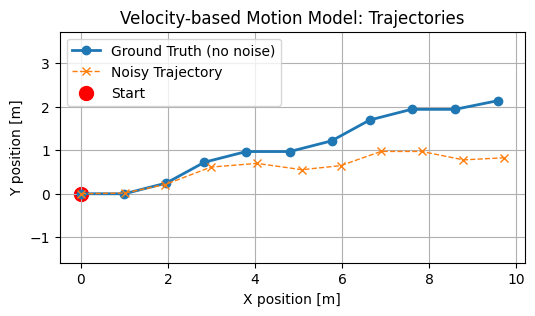

In [38]:
# Plotting the trajectories
plt.figure(figsize=(6, 3))  # Adjust figure size for better visibility
plt.plot(traj_gt[:,0], traj_gt[:,1], 'o-', label='Ground Truth (no noise)', linewidth=2)
plt.plot(traj_noisy[:,0], traj_noisy[:,1], 'x--', label='Noisy Trajectory', linewidth=1)
plt.scatter(initial_pose[0], initial_pose[1], c='red', s=100, label='Start')
plt.title('Velocity-based Motion Model: Trajectories')
plt.xlabel('X position [m]')
plt.ylabel('Y position [m]')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


To further understand the impact of uncertainty, we also visualize the effects of noise applied independently to each velocity command — translational ($ v $), rotational ($ w $), and orientation adjustment ($ \gamma $) — and their combined effect.

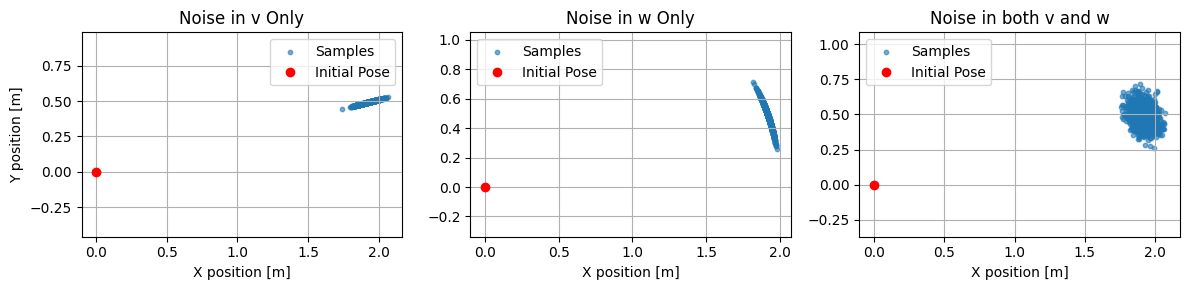

In [39]:
# Define two distinct commands and a combined one
initial_pose = np.array([0.0, 0.0, 0.0])
control = [2.0, 0.5, 0.2]  # v, w, gamma
num_samples = 1000

# Scenarios: noise on one control at a time
scenarios = {
    'v Only':      [0.05, 0.00, 0.00],
    'w Only':      [0.00, 0.075, 0.00],
    'both v and w': [0.05, 0.075, 0.00]
} # Play with these values to see different effects

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 3))  # Adjust figure size for better visibility

for ax, (title, noise) in zip(axes, scenarios.items()):
    # Sample particles
    particles = np.array([
        motion_model_velocity(control, initial_pose, dt=1.0, noise_std=noise)
        for _ in range(num_samples)
    ])
    # Plot
    ax.scatter(particles[:,0], particles[:,1], s=10, alpha=0.6, label='Samples')
    ax.plot(initial_pose[0], initial_pose[1], 'ro', linestyle='None', label='Initial Pose')
    
    ax.set_title(f'Noise in {title}')
    ax.set_xlabel('X position [m]')
    if ax is axes[0]:
        ax.set_ylabel('Y position [m]')
    ax.axis('equal')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

---

##### 🕹️ `Python example #3: Interactive Odometry Motion Model`

In this example, we’ll build an interactive demonstration of the <span style="color:#ffa500">**odometry-based motion model** </span>. You can use the arrow keys to drive the robot, and you’ll see:

- <span style="color:#00703c"> **Left panel (Ground Truth):** </span>  
  The true robot pose updates exactly as you command (no noise).

- <span style="color:#00703c"> **Right panel (Noisy):** </span>  
  The actual executed trajectory that includes the inevitable noise we typically encounter in real-world systems. 

Initialize `pygame` window parameters.

In [40]:
# --- Setup ---
import pygame
import sys
import numpy as np

pygame.init()

# Panel and window sizes
PANEL_SIZE = (1200, 900)  # Adjust panel size as needed
WINDOW_SIZE = (PANEL_SIZE[0] * 2, PANEL_SIZE[1])

clock = pygame.time.Clock()


Set initial robot poses at center; store trajectory histories.

In [41]:

# --- State ---
# Ground truth and noisy poses: [x, y, theta]
# Initialize both poses at the center of the panel
gt_pose    = np.array([PANEL_SIZE[0]//2, PANEL_SIZE[1]//2, 0.0])
noisy_pose = gt_pose.copy()

# Trajectory histories
gt_traj    = [gt_pose.copy()]
noisy_traj = [noisy_pose.copy()]


Define odometry noise and movement increments.

In [42]:

# --- Parameters ---
# Odometry noise std: [rot1, trans, rot2]
noise_std = [0.05, 0.075, 0.05]  # radians, pixels, radians

# Command magnitudes
TRANS_STEP = 20                   # pixels forward
ROT_STEP   = np.deg2rad(15)       # radians rotation

We apply the noise on the two rotations and one translation on the odometry motion model we defined earlier.

Each frame (capped at 10 FPS), we clear the screen, draw the two panel borders, and handle events. On an <span style="color:#ffa500">**arrow‐key**</span> press we compute a control vector `u` and then update both the ground‐truth pose (without noise) and the noisy pose (with sampled odometry noise), appending each to its trajectory history. Finally, we render the ground‐truth path as blue lines and a triangular robot, and the noisy path as yellow lines and a circular marker, before flipping the display. The loop continues until the window is closed, at which point we exit `pygame` cleanly.

In [43]:
screen = pygame.display.set_mode(WINDOW_SIZE)
pygame.display.set_caption("Interactive Odometry Motion Model")

# --- Main Loop ---
running = True
while running:
    # Cap to 10 FPS
    clock.tick(10)
    
    # Clear screen
    screen.fill((30, 30, 30))
    
    # Draw panel boundaries
    pygame.draw.rect(screen, (200, 200, 200), (0, 0, *PANEL_SIZE), 2)
    pygame.draw.rect(screen, (200, 200, 200), (PANEL_SIZE[0], 0, *PANEL_SIZE), 2)
    pygame.draw.line(screen, (200, 200, 200), (PANEL_SIZE[0], 0), (PANEL_SIZE[0], PANEL_SIZE[1]), 2)
    
    # Handle input
    for ev in pygame.event.get():
        if ev.type == pygame.QUIT:
            running = False
        elif ev.type == pygame.KEYDOWN:
            # Define command u = [rot1, trans, rot2]
            if ev.key == pygame.K_UP:
                u = [0.0, TRANS_STEP, 0.0]
            elif ev.key == pygame.K_LEFT:
                # turn left by negative angle to match intuitive arrow direction
                u = [-ROT_STEP, 0.0, 0.0]
            elif ev.key == pygame.K_RIGHT:
                # turn right by positive angle
                u = [ROT_STEP, 0.0, 0.0]
            else:
                u = None
            
            if u is not None:
                # 1) Update ground truth (no noise)
                gt_pose = motion_model_odometry(u, gt_pose, noise_std=[0,0,0])
                gt_traj.append(gt_pose.copy())
                
                # 2) Update noisy pose
                noisy_pose = motion_model_odometry(u, noisy_pose, noise_std)
                noisy_traj.append(noisy_pose.copy())
    
    # --- Draw Left Panel: Ground Truth ---
    for i in range(1, len(gt_traj)):
        x0, y0, _ = gt_traj[i-1]
        x1, y1, _ = gt_traj[i]
        pygame.draw.line(screen, (0, 150, 255), (x0, y0), (x1, y1), 2)
    # Draw ground truth robot as a triangle
    gt_x, gt_y, gt_th = gt_pose
    pts = [
        (gt_x + 15*np.cos(gt_th), gt_y + 15*np.sin(gt_th)),
        (gt_x + 10*np.cos(gt_th + 2.5), gt_y + 10*np.sin(gt_th + 2.5)),
        (gt_x + 10*np.cos(gt_th - 2.5), gt_y + 10*np.sin(gt_th - 2.5))
    ]
    pygame.draw.polygon(screen, (0, 150, 255), pts)
    
    # --- Draw Right Panel: Noisy Trajectory ---
    offset = PANEL_SIZE[0]
    # Draw noisy trajectory
    for i in range(1, len(noisy_traj)):
        x0, y0, _ = noisy_traj[i-1]
        x1, y1, _ = noisy_traj[i]
        pygame.draw.line(screen, (200, 200, 60), (x0 + offset, y0), (x1 + offset, y1), 2)
    # Draw noisy robot pose as a circle
    np_x, np_y, _ = noisy_pose
    pygame.draw.circle(screen, (200, 200, 60), (int(np_x) + offset, int(np_y)), 8)
    
    pygame.display.flip()

pygame.quit()
sys.exit()



SystemExit: 

#### ✔️ <span style="color:#a4d4a3">Conclusion</span>

This interactive example demonstrates a key concept in probabilistic robotics: <span style="color:#ffa500">**the motion we command is not always the motion we get**</span>. While the ground truth robot follows inputs exactly, the noisy trajectory highlights how real-world factors, like imperfect actuators, wheel slip, and sensor inaccuracies, cause deviation from expected motion. This visualizes why probabilistic motion models are essential in SLAM and robotic state estimation.

---

### 🔭 <span style="color:#a4d4a3">**Observation (Sensor) Models**</span>

An <span style="color:#ffa500">**observation model**</span> relates the robot's state to sensor measurements. It specifies the likelihood that a measurement $ z_t $ is obtained given the current state $ x_t $:

$$
p(z_t \mid x_t)
$$

As sensor measurements inherently contain noise and uncertainty, the observation model must explicitly account for this uncertainty.

Below, we present a simple example of a common observation model: the <span style="color:#ffa500">**Range-Bearing Observation Model**</span> for landmark perception.


#### <span style="color:#a4d4a3">Range-Bearing Sensor Model (Landmark-based)</span>

Consider a sensor such as a 2D LiDAR or radar that measures landmarks by providing:

- <span style="color:#00703c">**Range**:</span> distance from the robot to the landmark.
- <span style="color:#00703c">**Bearing**:</span> angle from the robot's orientation to the landmark.

Given:

- The robot’s current state: $ x_t = [x, y, \theta]^T $
- A landmark’s known position: $ m_j = [m_{j,x}, m_{j,y}]^T $

The observation measurement $ z_t^j $ to landmark $ j $ is described by:

<p align="center">
  <img src="../figures/range_bearing_model.png" alt="Robot Odometry" width="420"/>
</p>

$$
z_t^j = 
\begin{bmatrix}
r_j \\[6pt]
\varphi_j
\end{bmatrix}
=
\begin{bmatrix}
\sqrt{(m_{j,x} - x)^2 + (m_{j,y} - y)^2} \\[6pt]
\text{atan2}(m_{j,y} - y, m_{j,x} - x) - \theta
\end{bmatrix}
+ q
$$

where:

- $ r_j $ is the measured distance (range) to the landmark.
- $ \varphi_j $ is the measured angle (bearing) relative to the robot’s orientation.
- $ q $ represents the measurement noise, typically modeled as Gaussian noise:

$$
q \sim \mathcal{N}(0, Q)
$$

with covariance matrix:

$$
Q = 
\begin{bmatrix}
\sigma_{range}^2 & 0 \\[6pt]
0 & \sigma_{bearing}^2
\end{bmatrix}
$$

---

##### 📈`Python example #4: Range-bearing Sensor Model`

First, we define the <span style="color:#ffa500">**range-bearing sensor model**</span> according to the equations introduced earlier. We will simulate sensor measurements to landmarks, clearly demonstrating the difference between ideal measurements (noise-free) and realistic sensor measurements affected by Gaussian noise.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Range-bearing sensor model ---
def range_bearing_observation(x:np.array, landmark:np.array, noise_std:np.array=[0, 0]) -> np.array:
    """
    2D range-bearing sensor model with Gaussian noise.
    Inputs:
    - x: robot state [x, y, theta]
    - landmark: position [lx, ly]
    - noise_std: measurement noise standard deviations [range, bearing]
    Returns:
    - measurement [range, bearing]
    """
    dx = landmark[0] - x[0]
    dy = landmark[1] - x[1]
    
    # Ideal measurements
    r = np.sqrt(dx**2 + dy**2)
    phi = np.arctan2(dy, dx) - x[2]
    
    # Add Gaussian noise
    r_noisy = r + np.random.normal(0, noise_std[0])
    phi_noisy = phi + np.random.normal(0, noise_std[1])
    
    return np.array([r_noisy, phi_noisy])

Next, we initialize a known position for the robot and several landmark positions. Using our defined range-bearing sensor model, we simulate <span style="color:#ffa500">**sensor measurements**</span> to these landmarks, explicitly incorporating sensor noise.

In [ ]:

# Robot state and landmark positions
robot_pose = np.array([2.0, 3.0, np.pi/4])
landmarks = np.array([[5, 7], [1, 8], [7, 2]])

# Simulate noisy measurements
measurements = np.array([range_bearing_observation(robot_pose, lm, [0.08, 0.05]) for lm in landmarks])

Finally, we visualize the scenario by plotting the robot position, the ground truth landmark positions, and the noisy sensor measurements. This plot illustrates how sensor noise influences the accuracy of landmark observations and helps us understand the importance of probabilistic filtering methods in robotics.

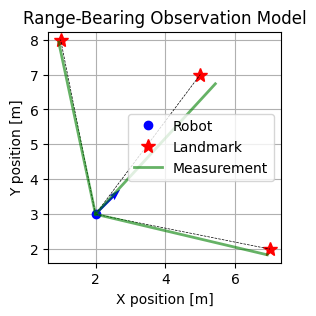

In [ ]:
# Plot robot, landmarks, and measurements
plt.figure(figsize=(3, 3))  # Adjust figure size for better visibility
plt.plot(robot_pose[0], robot_pose[1], 'bo', label='Robot')
plt.quiver(robot_pose[0], robot_pose[1], np.cos(robot_pose[2]), np.sin(robot_pose[2]), 
           color='blue', angles='xy', scale_units='xy', scale=1.0, width=0.01)

for idx, lm in enumerate(landmarks):
    plt.plot(lm[0], lm[1], 'r*', markersize=10, label='Landmark' if idx==0 else "")
    
    # Ideal measurement lines
    plt.plot([robot_pose[0], lm[0]], [robot_pose[1], lm[1]], 'k--', linewidth=0.5)
    
    # Noisy measurement lines (range-bearing)
    r, phi = measurements[idx]
    lm_noisy_x = robot_pose[0] + r * np.cos(robot_pose[2] + phi)
    lm_noisy_y = robot_pose[1] + r * np.sin(robot_pose[2] + phi)
    plt.plot([robot_pose[0], lm_noisy_x], [robot_pose[1], lm_noisy_y], 'g-', linewidth=2, alpha=0.6, label='Measurement' if idx==0 else "")

plt.grid(True)
plt.xlabel('X position [m]')
plt.ylabel('Y position [m]')
plt.title('Range-Bearing Observation Model')
plt.axis('equal')
plt.legend()
plt.show()

<details>
<summary><strong> 📝 <span style="color:#e74c3c">Note:</span> </strong> <em>What is the practical purpose of the observation model equations since we do not actually know the positions of the landmarks?</em> </summary>
<br>

In practice, the robot's sensors (like LiDAR or radar) only provide raw measurements of <span style="color:#ffa500">**range**</span> (distance) and <span style="color:#ffa500">**bearing**</span> (angle) relative to the robot's position and orientation. The landmark coordinates are not directly given by the sensor.

However, the <span style="color:#ffa500">**range-bearing observation model**</span> equations allow us to compute what measurements we <span style="color:#ffa500">**expect**</span> to see from a hypothesized robot position and orientation to a landmark whose position we estimate. 

These predicted measurements are crucial because we compare them with the actual sensor measurements. By quantifying differences between predicted and actual measurements, we iteratively update and refine our estimates of both the robot’s pose and landmark positions. This comparison process is fundamental to SLAM and localization, enabling robots to accurately map their environment and determine their location, even though real-world sensors provide noisy measurements and initial landmark positions are uncertain or unknown.

We will later see in detail how to incorporate these motion and observation models into the filtering algorithms (e.g., Kalman Filter, Particle Filter, Graph‐based SLAM) to perform state estimation.

</details>

---

##### 🕹️ `Python Example #5: Interactive Observation Model`


In this example, we'll create an interactive visualization of a <span style="color:#ffa500">**range-bearing sensor model**</span> using `pygame`. We will load a black-and-white image representing a simple floor plan. The visualization is split into two sections:

- <span style="color:#00703c">**Left panel:**</span> Displays the floor plan and simulates our rotating sensor (represented visually by a rotating beam).
- <span style="color:#00703c">**Right panel:**</span> Shows sensor measurements (landmark observations) as they are detected by the sensor.


We start by defining the essential parameters of our simulated sensor, including:

- <span style="color:#ffa500">**Maximum measurement range**</span> (in pixels), limiting how far the sensor beam can detect obstacles.
- <span style="color:#ffa500">**Rotation frequency**</span> of the sensor beam, which simulates how quickly our sensor completes a full rotation (here set to 10Hz).
- <span style="color:#ffa500">**Measurement noise parameters**</span>, specifying Gaussian noise added to both the measured range (distance) and bearing (angle) to realistically represent sensor inaccuracies.

In [ ]:
# This script visualizes a floor plan and occupancy map using Pygame
import pygame
import sys
import numpy as np

# Beam parameters
max_range   = 200
beam_speed  = 2 * np.pi * 10  # 10 rev/s
beam_angle  = 0.0

# Measurement noise std [px, rad]
noise_std = [1.0, np.deg2rad(0.5)]

# Persistence settings
landmark_duration_ms = 1_000_000 # landmark alive time in milliseconds
registered = []  # (x,y,time)


We load the floor plan and build the <em>"occupancy"</em> map based on the pixel values

In [ ]:
# Load & scale floor plan
floor_plan_orig = pygame.image.load('../figures/floor_plan.png')  # You can replace this with any black-and-white floor plan image
w_orig, h_orig = floor_plan_orig.get_size()
max_w, max_h = 500, 400   # half-size for clarity
scale = min(max_w / w_orig, max_h / h_orig)
w, h = int(w_orig * scale), int(h_orig * scale)

floor_plan = pygame.transform.smoothscale(floor_plan_orig, (w, h))

# Build occupancy map (True = wall)⌨️
arr = pygame.surfarray.array3d(floor_plan)
wall_mask = np.all(arr < 128, axis=2)

We then define a function, `cast_beam`, which simulates the sensor’s operation. Given the robot’s current pixel coordinates (controlled by the mouse), the current angle of the sensor beam, and the maximum sensor range, this function returns information about whether the beam hits an obstacle (black pixel) and, if so, at what distance.

In [ ]:
# --- Cast a beam ---
def cast_beam(pos:np.array, angle:float, max_r:float, noise_std:float=0.0) -> tuple:
    """
    Cast a beam from pos at angle up to max_r.
    Inputs:
    - pos: (x, y) starting position
    - angle: direction in radians
    - max_r: maximum range
    Returns (hit_pos, distance) or (None, max_r) if no hit.
    """
    x0, y0 = pos
    for d in range(int(max_r)):
        x = int(x0 + d * np.cos(angle))
        y = int(y0 + d * np.sin(angle))
        if x<0 or x>=w or y<0 or y>=h:
            return None, d
        if wall_mask[x, y]:
            return (x, y), d+np.random.normal(0, noise_std)
    return None, int(max_r)

Finally, we run the simulation in a continuous loop, visually updating the scene using `pygame`. Detected landmarks are registered and persistently displayed in the right-hand panel, showing how sensor measurements accumulate over time. 

👉 <span style="color:#00703c">**To interact:**</span>

Move your mouse cursor around the floor plan in the left panel. As you do, observe how landmarks appear on the right side, representing noisy sensor measurements detected by your simulated sensor.

In [ ]:
# Initialize pygame
pygame.init()

# Display setup: two panels side-by-side
screen = pygame.display.set_mode((w*2, h))
pygame.display.set_caption("Map & Sensor View")
clock = pygame.time.Clock()

# Main loop
running = True
while running:
    dt = clock.tick(60) / 1000.0
    now = pygame.time.get_ticks()
    beam_angle = (beam_angle + beam_speed * dt) % (2 * np.pi)

    for ev in pygame.event.get():
        if ev.type == pygame.QUIT:
            running = False

    # Clear screen
    screen.fill((50, 50, 50))

    # Left panel: Map + beam
    screen.blit(floor_plan, (0, 0))
    robot = np.array(pygame.mouse.get_pos())
    robot = robot.clip([0,0],[w-1,h-1])
    pygame.draw.circle(screen, (0,0,255), robot, 5)

    hit, dist = cast_beam(robot, beam_angle, max_range, noise_std[0])
    if hit:
        hx, hy = hit
        # true measurement
        true_bearing = np.arctan2(hy-robot[1], hx-robot[0])
        noisy_r = dist #+ np.random.normal(0, noise_std[0])
        noisy_b = true_bearing + np.random.normal(0, noise_std[1])
        mx = int(robot[0] + noisy_r * np.cos(noisy_b))
        my = int(robot[1] + noisy_r * np.sin(noisy_b))
        registered.append((mx, my, now))
        pygame.draw.line(screen, (255,0,0), robot, (hx, hy), 2)

    # Prune old landmarks
    registered = [(x,y,t) for (x,y,t) in registered if now-t<=landmark_duration_ms]

    # Right panel: Sensor-registered landmarks
    # white background
    pygame.draw.rect(screen, (0,0,0), (w, 0, w, h))
    for x, y, _ in registered:
        pygame.draw.circle(screen, (255,0,0), (x + w, y), 2)

    pygame.display.flip()

pygame.quit()
sys.exit()

SystemExit: 

---

##### 🕹️ `Python example #6: Combined Interactive Motion & Observation Model`

In this interactive demo, we control the robot with the keyboard arrows and see both motion and sensing in action:

- <span style="color:#00703c">**Left panel (Ground Truth)**</span>
  - The blue circle shows the robot’s true pose as you drive it (no noise).  
  - The blue line traces the ground truth trajectory behind the robot.

- <span style="color:#00703c">**Right panel (With Noise)**</span>
  - The yellow line shows the noisy trajectory produced by the odometry-based motion model (`sample_motion_model_odometry`).  
  - The red dots show the noisy range-bearing measurements (“landmarks”) registered by the sensor model at each scan.

<span style="color:#00703c">**How it works**:</span>  
1. <span style="color:#ffa500">**Arrow keys**</span> issue motion commands (forward, turn left, turn right).  
2. We update the <span style="color:#ffa500">**ground truth pose**</span> exactly (no noise) and record its trajectory.  
3. We update the <span style="color:#ffa500">**predicted pose**</span> by applying the same command through the noisy motion model, and record its trajectory.  
4. The sensor beam rotates at 10 Hz from the <span style="color:#ffa500">**predicted pose**</span>, casting rays until it hits a wall pixel in the floor plan (max range in pixels).  
5. We add Gaussian noise to both range and bearing, compute the noisy endpoint, and register it as a red landmark on the right panel.  

Move the robot around with the arrow keys and watch how motion noise and sensor noise affect your map of the environment!


In [ ]:
import pygame
import sys
import numpy as np

# --- Setup ---
pygame.init()

# Panel and window sizes
PANEL_W, PANEL_H = 600, 400  # Adjust panel size as needed
WINDOW_SIZE = (PANEL_W * 2, PANEL_H)
screen = pygame.display.set_mode(WINDOW_SIZE)
pygame.display.set_caption("Combined Motion & Sensor Demo")
clock = pygame.time.Clock()

# Load & scale floor plan for left panel
floor_plan_img = pygame.image.load('../figures/floor_plan.png') # Replace with any black-and-white floor plan image
floor_plan = pygame.transform.smoothscale(floor_plan_img, (PANEL_W, PANEL_H))

# Build occupancy map (True = wall) from scaled image
arr = pygame.surfarray.array3d(floor_plan)
wall_mask = np.all(arr < 128, axis=2)

# --- State ---
gt_pose    = np.array([PANEL_W//2, PANEL_H//2, 0.0])  # init pose
pred_pose  = gt_pose.copy()                           # init noisy pose
gt_traj    = [gt_pose.copy()]
pred_traj  = [pred_pose.copy()]
landmarks  = []    # list of (x, y, timestamp_ms)

# --- Parameters ---
motion_noise  = [0.02, 1.0, 0.02]       # [rot1, trans, rot2] noise
TRANS_STEP    = 10                     # pixels per UP
ROT_STEP      = np.deg2rad(15)         # radians per LEFT/RIGHT

beam_speed    = 2 * np.pi * 10         # rad/s (10 rev/s)
beam_angle    = 0.0
max_range_px  = 200

# SCAN_EVENT at 10 Hz
SCAN_EVENT = pygame.USEREVENT + 1
pygame.time.set_timer(SCAN_EVENT, 100)

# Precompute angles for full 360° sweep
NUM_BEAMS = 180
angles = np.linspace(0, 2*np.pi, NUM_BEAMS, endpoint=False)

# --- Main Loop ---
running = True
while running:
    dt = clock.tick(60) / 1000.0
    beam_angle = (beam_angle + beam_speed * dt) % (2 * np.pi)
    now = pygame.time.get_ticks()

    for ev in pygame.event.get():
        if ev.type == pygame.QUIT:
            running = False

        # motion commands
        elif ev.type == pygame.KEYDOWN:
            if ev.key == pygame.K_UP:
                cmd = [0.0, TRANS_STEP, 0.0]
            elif ev.key == pygame.K_LEFT:
                cmd = [-ROT_STEP, 0.0, 0.0]
            elif ev.key == pygame.K_RIGHT:
                cmd = [ROT_STEP, 0.0, 0.0]
            else:
                cmd = None

            if cmd is not None:
                gt_pose = motion_model_odometry(cmd, gt_pose)
                gt_traj.append(gt_pose.copy())
                pred_pose = motion_model_odometry(cmd, pred_pose, motion_noise)
                pred_traj.append(pred_pose.copy())

        # full 360° sensor scan at 10 Hz
        elif ev.type == SCAN_EVENT:
            for a in angles:
                hit, dist = cast_beam(gt_pose[:2], a, max_range_px, noise_std[0])                    
                if hit:
                    # Add noise to the measurement
                    # dist += np.random.normal(0, noise_std[0])
                    a += np.random.normal(0, noise_std[1])
                    hx, hy = hit
                    phi = a - gt_pose[2]                              # true bearing
                    # project measurement from predicted pose
                    mx = int(pred_pose[0] + dist * np.cos(pred_pose[2] + phi))
                    my = int(pred_pose[1] + dist * np.sin(pred_pose[2] + phi))
                    landmarks.append((mx, my, now))

    # prune landmarks older than 10s
    landmarks = [(x,y,t) for (x,y,t) in landmarks if now - t <= 1000000]

    # --- Left Panel: Map + GT Trajectory + Rotating Beam ---
    screen.fill((30,30,30), (0,0,PANEL_W,PANEL_H))
    screen.blit(floor_plan, (0,0))
    pygame.draw.rect(screen, (200,200,200), (0,0,PANEL_W,PANEL_H), 2)

    # draw GT trajectory
    for i in range(1, len(gt_traj)):
        x0,y0 = gt_traj[i-1][:2]; x1,y1 = gt_traj[i][:2]
        pygame.draw.line(screen, (0,150,255), (x0,y0), (x1,y1), 2)

    # draw GT robot
    gx,gy,gth = gt_pose
    pts = [
        (gx + 15*np.cos(gth),     gy + 15*np.sin(gth)),
        (gx + 10*np.cos(gth+2.5), gy + 10*np.sin(gth+2.5)),
        (gx + 10*np.cos(gth-2.5), gy + 10*np.sin(gth-2.5))
    ]
    pygame.draw.polygon(screen, (0,150,255), pts)

    # draw rotating beam
    bx, by = gt_pose[:2]
    # compute endpoint even if no hit
    hit, dist = cast_beam(gt_pose[:2], beam_angle, max_range_px)
    if hit:
        ex, ey = hit
    else:
        ex = int(bx + max_range_px * np.cos(beam_angle))
        ey = int(by + max_range_px * np.sin(beam_angle))
    pygame.draw.line(screen, (255,0,0), (int(bx), int(by)), (ex, ey), 2)

    # --- Right Panel: Noisy Trajectory + Projected Landmarks ---
    ox = PANEL_W
    screen.fill((255,255,255), (ox,0,PANEL_W,PANEL_H))
    pygame.draw.rect(screen, (200,200,200), (ox,0,PANEL_W,PANEL_H), 2)

    # predicted trajectory
    for i in range(1, len(pred_traj)):
        x0,y0 = pred_traj[i-1][:2]; x1,y1 = pred_traj[i][:2]
        pygame.draw.line(screen, (200,200,60), (x0+ox,y0), (x1+ox,y1), 2)

    # predicted robot
    px,py,_ = pred_pose
    pygame.draw.circle(screen, (200,200,60), (int(px)+ox, int(py)), 8)

    # projected landmarks
    for x,y,_ in landmarks:
        pygame.draw.circle(screen, (255,0,0), (x+ox, y), 2)

    pygame.display.flip()

pygame.quit()
sys.exit()


SystemExit: 

#### ✔️ <span style="color:#a4d4a3">Conclusion</span>

In this final example, we combine the motion and sensor models to show how a robot builds a map of its environment while navigating. As you control the robot, both motion and measurement noise affect its understanding of the world. The landmarks it observes are uncertain, and its position estimate drifts over time. This highlights why we need a <span style="color:#ffa500">**filtering method**</span> — like the Extended Kalman Filter (EKF) or particle filter — to <span style="color:#ffa500">**predict**</span> the robot's state and <span style="color:#ffa500">**correct**</span> it using noisy observations. Without such a filter, the robot's map and localization would quickly become unreliable.

---

### 📚 <span style="color:#a4d4a3">**Reading Material**</span>

**On Motion and Observation Models**
- Thrun et al.: *"Probabilistic Robotics"*, **Chapter 5 & 6**